In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
!pip install xmltodict

In [3]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 4.5 MB/s 
     |████████████████████████████████| 37.1 MB 48 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
import xmltodict
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [5]:
cd drive/MyDrive/CSC474/Project

/content/drive/MyDrive/CSC474/Project


In [173]:
def resize_image_with_BB(image, width, height, list_BB):
    h = image.shape[0]
    w = image.shape[1]

    new_size = (width, height)

    new_BB_list = []

    for i in range(len(list_BB)):

        x1, y1, x2, y2, l = list_BB[i]

        r_w = width/w
        r_h = height/h

        x1 *= r_w
        x2 *= r_w

        y1 *= r_h
        y2 *= r_h

        new_BB = (int(x1), int(y1), int(x2), int(y2), l)
        new_BB_list.append(new_BB)

    return cv2.resize(image, new_size, interpolation = cv2.INTER_AREA), new_BB_list

In [6]:
images = []
annotations = []

image_dir = os.getcwd() + '/data/images'
annot_dir = os.getcwd() + '/data/annotations'

for filename in os.listdir(annot_dir):
    annotations.append(filename)

for filename in os.listdir(image_dir):
    images.append(filename)

images = sorted(images)
annotations = sorted(annotations)

In [7]:
class_ids = [0,1,2]
class_names = {0:'without_mask', 1: 'with_mask', 2:'mask_weared_incorrect'}
maxSize = int(416*1.1)
img_transform = A.Compose(
    [
      A.LongestMaxSize(max_size = maxSize),
      A.PadIfNeeded(
            min_height=int(maxSize),
            min_width=int(maxSize),
            border_mode=cv2.BORDER_CONSTANT,
        ),
      A.RandomSizedBBoxSafeCrop(width=416, height=416, erosion_rate=0.2),
      A.Normalize(mean= [0,0,0], std=[1,1,1], max_pixel_value=255,),   
      ToTensorV2(),
    ],
    bbox_params = A.BboxParams(format= "pascal_voc", label_fields=[]),
)

In [174]:
from tensorflow.keras.preprocessing.image import img_to_array

bboxes0 = []
bboxes1 = []
bboxes2 = []
B0 = []
B1 = []
B2 = []
dataimage = []
classes = {'without_mask':0, 'with_mask':1, 'mask_weared_incorrect':2}

for i in range (0,len(annotations)):
    annot_file = open(os.path.join(annot_dir, annotations[i]), 'r')
    image_filename = os.path.join(image_dir, images[i])

    annot_data = annot_file.read()
    annot_dict = xmltodict.parse(annot_data)['annotation']

    image = cv2.imread(image_filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    objects = annot_dict['object']
    B = []
    if isinstance(objects, list):
        for item in objects:
          xmin = int(item['bndbox']['xmin'])
          ymin = int(item['bndbox']['ymin'])
          xmax = int(item['bndbox']['xmax'])
          ymax = int(item['bndbox']['ymax'])
          label = classes[item['name']] # 1-hot encoding.

          bbox = (xmin, ymin, xmax, ymax, label)
          B0.append(bbox)
          B1.append(bbox)
          B2.append(bbox)
    else:
        xmin = int(item['bndbox']['xmin'])
        ymin = int(item['bndbox']['ymin'])
        xmax = int(item['bndbox']['xmax'])
        ymax = int(item['bndbox']['ymax'])
        label = classes[item['name']] # 1-hot encoding.

        bbox = (xmin, ymin, xmax, ymax, label)
        B0.append(bbox)
        B1.append(bbox)
        B2.append(bbox)

    image, B0 = resize_image_with_BB(image, 416, 416, B0)
    _, B1 = resize_image_with_BB(image, 32, 32, B1)
    _, B2 = resize_image_with_BB(image, 16, 16, B2)

    dataimage.append(image)
    bboxes0.append(B0)
    bboxes1.append(B1)
    bboxes2.append(B2)

In [93]:
x = torch.from_numpy(dataimage[0])
x = torch.unsqueeze(x, -1)
x = x.reshape((1,3,x.shape[0], x.shape[1]))
x = x.float()

In [94]:
x.shape

torch.Size([1, 3, 416, 416])

config = [
  
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

In [95]:
# Hyperparameters
leakyReLuAlpha = 0.1
bn_momentum = 0.999

In [98]:
class yolo_model(nn.Module):

    def __init__(self, leakyReLuAlpha = 0.1, bn_momentum = 0.999):
        super(yolo_model, self).__init__()
        self.leakyReLuAlpha = leakyReLuAlpha
        self.usebias = True
        self.bn_momentum = bn_momentum
        self.layers = self.createModelLayers()

    def createModelLayers(self):
        layers = nn.ModuleList()

        ''' convs '''
        ''' convs '''
        layer = nn.Conv2d(3, 32, 3, 1, bias= self.usebias, padding=1)
        layers.append(layer)
        layer = nn.BatchNorm2d(32, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        layer = nn.Conv2d(32, 64, 3, 2, bias = self.usebias, padding=1)
        layers.append(layer)
        layer = nn.BatchNorm2d(64, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        ''' residual '''
        layer1a = nn.Conv2d(64, 32, 1, bias = self.usebias, padding=0)
        layer1b = nn.BatchNorm2d(32, momentum= self.bn_momentum)
        layer1c = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)

        layer2a = nn.Conv2d(32, 64, 3, bias= self.usebias, padding=1)
        layer2b = nn.BatchNorm2d(64, momentum= self.bn_momentum)
        layer2c = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        
        layer = nn.Sequential(layer1a,layer1b,layer1c,layer2a,layer2b,layer2c)
        layers.append(layer)
        
        ''' convs '''
        layer = nn.Conv2d(64, 128, 3, 2, bias = self.usebias, padding=1)
        layers.append(layer)
        layer = nn.BatchNorm2d(128, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        ''' 2 resiudal repeats '''
        layer1a = nn.Conv2d(128, 64, 1, bias = self.usebias, padding=0)
        layer1b = nn.BatchNorm2d(64, momentum= self.bn_momentum)
        layer1c = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)

        layer2a = nn.Conv2d(64, 128, 3, bias= self.usebias, padding=1)
        layer2b = nn.BatchNorm2d(128, momentum= self.bn_momentum)
        layer2c = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        
        for i in range(0,2):
          layer = nn.Sequential(layer1a,layer1b,layer1c,layer2a,layer2b,layer2c)
          layers.append(layer)

        ''' convs '''
        layer = nn.Conv2d(128, 256, 3, 2, bias = self.usebias, padding=1)
        layers.append(layer)
        layer = nn.BatchNorm2d(256, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        ''' 8 residual repeats '''
        layer1a = nn.Conv2d(256, 128, 1, bias = self.usebias, padding=0)
        layer1b = nn.BatchNorm2d(128, momentum= self.bn_momentum)
        layer1c = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)

        layer2a = nn.Conv2d(128, 256, 3, bias= self.usebias, padding=1)
        layer2b = nn.BatchNorm2d(256, momentum= self.bn_momentum)
        layer2c = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        
        for i in range(0,8):
          layer = nn.Sequential(layer1a,layer1b,layer1c,layer2a,layer2b,layer2c)
          layers.append(layer)

        ''' convs '''
        layer = nn.Conv2d(256, 512, 3, 2, bias = self.usebias, padding=1)
        layers.append(layer)
        layer = nn.BatchNorm2d(512, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        ''' 8 residual repeats '''
        layer1a = nn.Conv2d(512, 256, 1, bias = self.usebias, padding=0)
        layer1b = nn.BatchNorm2d(256, momentum= self.bn_momentum)
        layer1c = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)

        layer2a = nn.Conv2d(256, 512, 3, bias= self.usebias, padding=1)
        layer2b = nn.BatchNorm2d(512, momentum= self.bn_momentum)
        layer2c = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        
        for i in range(0,8):
          layer = nn.Sequential(layer1a,layer1b,layer1c,layer2a,layer2b,layer2c)
          layers.append(layer)
        
        ''' convs '''
        layer = nn.Conv2d(512, 1024, 3, 2, bias = self.usebias, padding=1)
        layers.append(layer)
        layer = nn.BatchNorm2d(1024, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        ''' 4 residual repeats '''
        layer1a = nn.Conv2d(1024, 512, 1, bias = self.usebias, padding=0)
        layer1b = nn.BatchNorm2d(512, momentum= self.bn_momentum)
        layer1c = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
      
        layer2a = nn.Conv2d(512, 1024, 3, bias= self.usebias, padding=1)
        layer2b = nn.BatchNorm2d(1024, momentum= self.bn_momentum)
        layer2c = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        
        for i in range(0,4):
          layer = nn.Sequential(layer1a,layer1b,layer1c,layer2a,layer2b,layer2c)
          layers.append(layer)
        
        ''' convs '''
        layer = nn.Conv2d(1024, 512, 1, 1, bias = self.usebias, padding=0)
        layers.append(layer)
        layer = nn.BatchNorm2d(512, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        layer = nn.Conv2d(512, 1024, 3, 1, bias = self.usebias, padding=1)
        layers.append(layer)
        layer = nn.BatchNorm2d(1024, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        ''' scale prediction '''
        layer = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=1, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1)
        )
        layers.append(layer)

        layer = nn.Conv2d(1024, 512, kernel_size=1, padding=0)
        layers.append(layer)
        layer = nn.BatchNorm2d(512)
        layers.append(layer)
        layer = nn.LeakyReLU(0.1)
        layers.append(layer)

        layer = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size= 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 24, kernel_size= 1)
        )
        layers.append(layer)

        ''' convs '''
        layer = nn.Conv2d(512, 256, 1, 1, bias = self.usebias, padding=0)
        layers.append(layer)
        layer = nn.BatchNorm2d(256, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        ''' upsampling '''
        layer = nn.Upsample(scale_factor= 2)
        layers.append(layer,)

        ''' convs '''
        layer = nn.Conv2d(768, 256, 1, 1, bias = self.usebias, padding=0)
        layers.append(layer)
        layer = nn.BatchNorm2d(256, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        layer = nn.Conv2d(256, 512, 3, 1, bias = self.usebias, padding=1)
        layers.append(layer)
        layer = nn.BatchNorm2d(512, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        ''' scale prediction '''
        layer = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1)
        )
        layers.append(layer)

        layer = nn.Conv2d(512, 256, kernel_size=1, padding=0)
        layers.append(layer)
        layer = nn.BatchNorm2d(256)
        layers.append(layer)
        layer = nn.LeakyReLU(0.1)
        layers.append(layer)

        layer = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size= 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 24, kernel_size= 1)
        )
        layers.append(layer)

        ''' convs '''
        layer = nn.Conv2d(256, 128, 1, 1, bias = self.usebias, padding=0)
        layers.append(layer)
        layer = nn.BatchNorm2d(128, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        ''' upsampling '''
        layer = nn.Upsample(scale_factor= 2)
        layers.append(layer)

        ''' convs '''
        layer = nn.Conv2d(384, 128, 1, 1, bias = self.usebias, padding=0)
        layers.append(layer)
        layer = nn.BatchNorm2d(128, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        layer = nn.Conv2d(128, 256, 3, 1, bias = self.usebias, padding=1)
        layers.append(layer)
        layer = nn.BatchNorm2d(256, momentum= self.bn_momentum)
        layers.append(layer)
        layer = nn.LeakyReLU(negative_slope= self.leakyReLuAlpha)
        layers.append(layer)

        ''' scale prediction '''
        layer = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1)
        )
        layers.append(layer)

        layer = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        layers.append(layer)
        layer = nn.BatchNorm2d(128)
        layers.append(layer)
        layer = nn.LeakyReLU(0.1)
        layers.append(layer)

        layer = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size= 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 24, kernel_size= 1)
        )
        layers.append(layer)
        return layers

    def evaluateModel(self, inputtensor):
        route = []
        output = []
        x = self.layers[0](inputtensor)
        x = self.layers[1](x)
        x = self.layers[2](x)
        
        x = self.layers[3](x)
        x = self.layers[4](x)
        x = self.layers[5](x)
        
        x = x + self.layers[6](x)
        
        x = self.layers[7](x)
        x = self.layers[8](x)
        x = self.layers[9](x)

        x = x + self.layers[10](x)
        x = x + self.layers[11](x)
        
        x = self.layers[12](x)
        x = self.layers[13](x)
        x = self.layers[14](x)
        
        x = x + self.layers[15](x)
        x = x + self.layers[16](x)
        x = x + self.layers[17](x)
        x = x + self.layers[18](x)
        x = x + self.layers[19](x)
        x = x + self.layers[20](x)
        x = x + self.layers[21](x)
        x = x + self.layers[22](x)
        route.append(x)
        
        x = self.layers[23](x)
        x = self.layers[24](x)
        x = self.layers[25](x)
        
        x = x + self.layers[26](x)
        x = x + self.layers[27](x)
        x = x + self.layers[28](x)
        x = x + self.layers[29](x)
        x = x + self.layers[30](x)
        x = x + self.layers[31](x)
        x = x + self.layers[32](x)
        x = x + self.layers[33](x)
        route.append(x)
        
        x = self.layers[34](x)
        x = self.layers[35](x)
        x = self.layers[36](x)
        
        x = x + self.layers[37](x)
        x = x + self.layers[38](x)
        x = x + self.layers[39](x)
        x = x + self.layers[40](x)

        x = self.layers[41](x)
        x = self.layers[42](x)
        x = self.layers[43](x)
        
        x = self.layers[44](x)
        x = self.layers[45](x)
        x = self.layers[46](x)

        x = self.layers[47](x)
        x = self.layers[48](x)
        x = self.layers[49](x)
        xx = self.layers[50](x)
        x = self.layers[51](xx)
        x = x.reshape(xx.shape[0], 3, 8, xx.shape[2], xx.shape[3]).permute(0,1,3,4,2)
        output.append(x)

        x = self.layers[52](xx)
        x = self.layers[53](x)
        x = self.layers[54](x)
        
        x = self.layers[55](x)
        x = torch.cat([x, route[-1]], dim=1)
        route.pop()

        x = self.layers[56](x)
        x = self.layers[57](x)
        x = self.layers[58](x)
        
        x = self.layers[59](x)
        x = self.layers[60](x)
        x = self.layers[61](x)
        
        x = self.layers[62](x)
        x = self.layers[63](x)
        x = self.layers[64](x)
        xx = self.layers[65](x)
        x = self.layers[66](xx)
        x = x.reshape(xx.shape[0], 3, 8, xx.shape[2], xx.shape[3]).permute(0,1,3,4,2)
        output.append(x)

        x = self.layers[67](xx)
        x = self.layers[68](x)
        x = self.layers[69](x)
        
        x = self.layers[70](x)
        x = torch.cat([x, route[-1]], dim=1)
        route.pop()

        x = self.layers[71](x)
        x = self.layers[72](x)
        x = self.layers[73](x)
        
        x = self.layers[74](x)
        x = self.layers[75](x)
        x = self.layers[76](x)

        x = self.layers[77](x)
        x = self.layers[78](x)
        x = self.layers[79](x)
        xx = self.layers[80](x)
        x = self.layers[81](xx)
        x = x.reshape(xx.shape[0], 3, 8, xx.shape[2], xx.shape[3]).permute(0,1,3,4,2)
        output.append(x)

        return output

In [99]:
num_classes = 3
IMAGE_SIZE = 224
model = yolo_model()
out = model.evaluateModel(x)

In [100]:
model.layers

ModuleList(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.999, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.999, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1)
  (6): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.999, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.999, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.999, affine=True, track_running_stats=True)
  (9): Lea

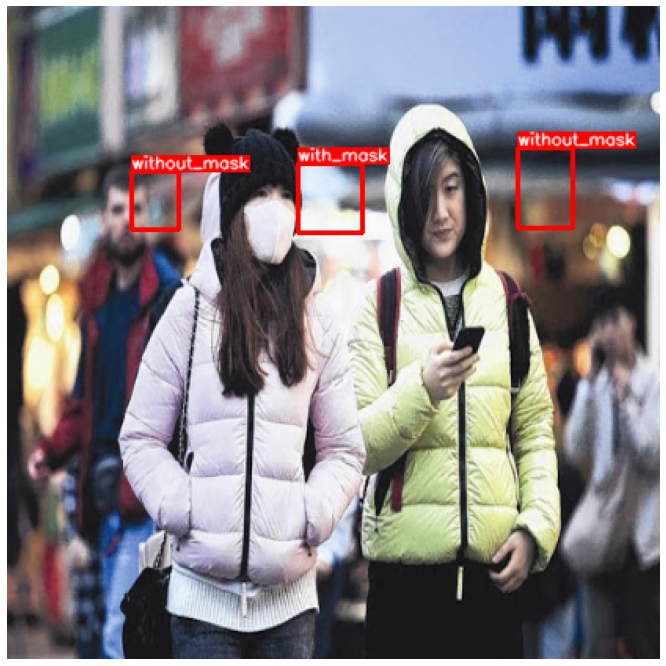

In [101]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
img = dataimage[0]
for boundingbox in bboxes[0]:
    x_min, y_min, x_max, y_max ,label= boundingbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), BOX_COLOR, 2)
    class_name = class_names[label]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, text=class_name, org=(x_min, y_min - int(0.3 * text_height)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.35, color=TEXT_COLOR, lineType=cv2.LINE_AA,)
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(img)

In [138]:
def iou(b1, b2, is_midpt=False):
    """
    :params: b1 is the first bounding box - b1 = (x1, y1, x2, y2)
    :params: b2 is the second bounding box
    :return: The intersection over union area of b1 and b2
    """

    if is_midpt:
        b1, b2 = get_box_cords_from_midpt(b1, b2)

    b1_x1, b1_y1, b1_x2, b1_y2 = b1
    b2_x1, b2_y1, b2_x2, b2_y2 = b2
    #print("B1: \n",b1)
    #print("B2: \n",b2)


    # the following 4 points (i_ ) represent the intersection box
    i_x1 = max(b1_x1, b2_x1)
    i_y1 = max(b1_y1, b2_y1)

    i_x2 = min(b1_x2, b2_x2)
    i_y2 = min(b1_y2, b2_y2)

    i_area = abs(i_x1 - i_x2) * abs(i_y1 - i_y2)

    u_area = abs(b1_x1 - b1_x2) * abs(b1_y1 - b1_y2) + \
             abs(b2_x1 - b2_x2) * abs(b2_y1 - b2_y2)


    return i_area/u_area


def get_box_cords_from_midpt(b1, b2):
    xm1, ym1, w1, h1 = b1
    xm2, ym2, w2, h2 = b2

    b1_x1 = xm1 - w1/2
    b1_y1 = ym1 - h1/2
    b1_x2 = xm1 + w1/2
    b1_y2 = ym1 + h1/2

    b2_x1 = xm2 - w2/2
    b2_y1 = ym2 - h2/2
    b2_x2 = xm2 + w2/2
    b2_y2 = ym2 + h2/2
    

    return (b1_x1, b1_y1, b1_x2, b1_y2), (b2_x1, b2_y1, b2_x2, b2_y2)

def nonmax_sup(b1, b2, b1_p, b2_p, is_midpt=False, iou_threshold=0.5):
    """
    Non-max suppression for bounding boxes.
    Function calculates IOU, and if the value if above the threshold, rejects the
    box with lower probability
    :return: -1 indicates the lower probability box should be rejected
              0 means it should be kept
    """
    max_p = max(b1_p, b2_p)
    iou = iou(b1, b2, is_midpt)

    if iou > iou_threshold:
        return -1
    
    return 0


# https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize_same_aspect_ratio(image, width = -1, height = -1):
    new_size = 0
    h = image.shape[0]
    w = image.shape[1]

    if width == -1:
        ratio = height / float(h)
        new_size = (int(w * ratio), height)
    else:
        ratio = width / float(w)
        new_size = (width, int(h * ratio))

    return cv2.resize(image, new_size, interpolation = cv2.INTER_AREA)


In [156]:
def _get_grid_BBs(target, S=13):
    """
    The incoming target variable is a list of all the
    BBs present in an image
    Assume that the image is divided into SxS grids and figure out of
    which grid does the BB land in
    """

    grid_target = -1*np.ones((S, S, 5))

    for b in target:
        x1, y1, x2, y2, l = b
        mid_x = abs(x1 - x2)/2
        mid_y = abs(y1 - y2)/2

        s1 = int(mid_y/S)
        s2 = int(mid_x/S)

        grid_target[s1, s2] = [x1, y1, x2, y2, l]

    return grid_target

def _get_softmax(x):
    l = []
    s = 0
    for xi in x:
        s += math.e**xi
    
    for xi in x:
        l.append(xi/s)

    return l


def loss(pred, target, B=2, S=13):
    """
    The pred size should be (SxSx(B*E + C))
        S - grid size
        B - Number of bounding boxes (number of predictions) per grid cell
        E - Number of elements predicted per box
        C - Number of classes
    Format of predicted elements, E - [x1, y1, w1, h1, conf1, x2... conf_n, class_probs]
        x, y - center point of the BB relative to the grid cell; relative range of [0, 1]
        w, h - width, height of the BB relative to the image; relative range of [0, 1]
        conf - Defined as Pr(obj) * IOU(pred, truth)
               0 if no obj
    """

    def get_best_box(arr, t_bb):
        st = 0
        end = 5
        max_bb = []
        max_iou = -1
        best_conf = -1 # confidence of the best box

        # get the BB with the box prob
        for b in range(B):
            x1, y1, x2, y2, conf = arr[st: end]
            st = end
            end += 5

            bb = [x1, y1, x2, y2]
            i = iou(bb, t_bb)

            if i > max_iou:
                max_bb = bb
                max_iou = i
                best_conf = conf

        return max_bb, max_iou, best_conf

    lmbda = 0.5

    target = _get_grid_BBs(target, S)

    loss_1 = 0 # TODO Also update these names
    loss_2 = 0
    loss_3 = 0
    loss_4 = 0

    # iterate over each grid (per image)
    for s1 in range(S):
        for s2 in range(S):    
            # this should have B instances of [x1, y1, x2, y2, label] # TODO Update this
            # and then class probabilites

            arr = pred[s1, s2]
            arr2 = target[s1, s2]
            x1, y1, x2, y2, gd_label = arr2
            t_bb = [x1, y1, x2, y2]

            # TODO check if there are any boxes at all
            # TODO_UPDATE - this might not be needed as every grid predicts B number of BBs
            best_bb, best_iou, pred_conf = get_best_box(arr, t_bb)

            x1, y1, x2, y2 = best_bb

            # The BB with the highest IOU (with the GD) will be the box responsible
            # for detecting

            if gd_label != -1:
                loss_1 += (x1 - t_bb[0])**2 + \
                    (x2 - t_bb[2])**2 + \
                    (y1 - t_bb[1])**2 + \
                    (y2 - t_bb[3])**2

            bb_h = abs(y1 - y2)
            bb_w = abs(x1 - x2)

            t_bb_h = abs(t_bb[1] - t_bb[3])
            t_bb_w = abs(t_bb[0] - t_bb[2])

            if gd_label != -1:
                loss_2 += (math.sqrt(bb_h) - math.sqrt(t_bb_h))**2 + \
                    (math.sqrt(bb_w) - math.sqrt(t_bb_w))**2
            
            if gd_label != -1:
                a = [float(x) for x in arr[5*B:]]
                pred_class_probs = _get_softmax(a)

                # -1 because all the probability goes to the gd label
                if pred_class_probs[int(gd_label)] > 0:
                  loss_4 += -1 * math.log(pred_class_probs[int(gd_label)])


    return (loss_1 + loss_2 + loss_3 + loss_4)

In [175]:
import math

num_classes = 3
IMAGE_SIZE = 224
model = yolo_model()

epochs = 3
optim = torch.optim.Adam(model.parameters(), lr=0.001)
cnt = 0

for epoch in range(epochs):
  for image in dataimage:
    x = torch.from_numpy(image)
    x = torch.unsqueeze(x, -1)
    x = x.reshape((1,3,x.shape[0], x.shape[1]))
    x = x.float()
    out = model.evaluateModel(x)
    l = loss(out[0][0][0], bboxes0[cnt], B=1, S=13) + loss(out[1][0][0], bboxes1[cnt], B=1, S=26) + loss(out[2][0][0], bboxes2[cnt], B=1, S=52)
    
    optim.zero_grad()
    l.backward()
    optim.step()
    cnt +=1

IndexError: ignored